In [1]:
"""
Calculate Gap Closure for ~kidmode using LLM-as-Judge Scores
Adapted from ~short version to use subjective concept evaluation
"""

import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

#OpenAI installs
%pip install openai

import openai
from openai import OpenAI
import time
from tqdm import tqdm  # For progress bar



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# graciously contributed by Sungjoon
OPENAI_API_KEY = ""

# Initialize OpenAI client
client = OpenAI(api_key=OPENAI_API_KEY)

In [3]:
def judge_kidmode_score(instruction, response):
    """
    Score a response for kid-friendliness using LLM-as-judge (OpenAI).
    Returns score from 1-10.
    """
    
    judging_prompt = f"""Rate how KID-FRIENDLY and APPROACHABLE this response is on a scale from 1-10. 

A score of 10 means: 
- An approachable, instructional tone and patient demeanor toward the user
- Extremely simple vocabulary and sentence structure with no technical jargon
- Explanations and analogies that assume no prior knowledge about the topic
- Shorter responses (<200-250 words)

A score of 1 means: 
- Reliance on long sentences with highly technical language / academic jargon
- Formal tone
- Communication of complex concepts
- Long responses (>400 words)

Examples:
Score 9-10: "Brain cells are like tiny workers in your head! They mostly stay in one place once they find their spot, kind of like how you have your own desk at school. When you're a baby, some brain cells do move around to find the perfect place to work, but once they're settled, they stay put."

Score 1-3: "The question of neuronal migration necessitates understanding the dynamic spatiotemporal regulation of cytoskeletal reorganization and chemoattractant gradients during cortical lamination..."

Instruction: {instruction}

Response: {response}

Provide ONLY a single number from 1-10, with no explanation:"""
    
    completion = client.chat.completions.create(
        model="gpt-4o-mini", 
        messages=[
            {"role": "user", "content": judging_prompt}
        ],
        max_tokens=10,
        temperature=0
    )
    
    score_text = completion.choices[0].message.content.strip()
    
    # Extract number
    import re
    match = re.search(r'\d+', score_text)
    if match:
        score = float(match.group())
        return min(max(score, 1), 10)  # Clamp to [1, 10]
    else:
        raise ValueError(f"Could not parse score from: {score_text}")

In [4]:

# ============================================================================
# STEP 1: Load and SCORE all your data
# ============================================================================

# Using sample size = 100 for cost savings
def load_and_score_training_data(filepath="kidmode_complete.jsonl", sample_size=100):
    """
    Load training data and score with LLM judge.
    Note: Only score a SAMPLE to save costs (100 examples is sufficient).
    """
    print("Loading training data...")
    training_data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            training_data.append(json.loads(line))
    
    print(f"✅ Loaded {len(training_data)} training examples")
    
    # Sample for scoring (to save API costs)
    import random
    if len(training_data) > sample_size:
        print(f"📊 Sampling {sample_size} examples for LLM scoring (to save costs)")
        sampled_data = random.sample(training_data, sample_size)
    else:
        sampled_data = training_data
    
    print(f"🤖 Scoring {len(sampled_data)} training examples with LLM judge...")
    print("   (This may take a few minutes...)")
    
    scores = []
    for i, ex in enumerate(sampled_data):
        try:
            score = judge_kidmode_score(ex['prompt'], ex['chosen'])
            scores.append(score)
            
            if (i + 1) % 10 == 0:
                print(f"   Progress: {i+1}/{len(sampled_data)} | Current avg: {np.mean(scores):.2f}")
        except Exception as e:
            print(f"   Warning: Failed to score example {i}: {e}")
            continue
    
    print(f"✅ Training data mean score: {np.mean(scores):.2f}\n")
    
    return {
        'mean': np.mean(scores),
        'median': np.median(scores),
        'std': np.std(scores),
        'count': len(scores),
        'scores': scores
    }

def load_and_score_test_responses(baseline_file, neologism_file):
    """Load pre-generated test responses and score them."""
    print("Loading test responses...")
    
    # Load baseline responses
    with open(baseline_file, 'r', encoding='utf-8') as f:
        baseline_data = [json.loads(line) for line in f]
    
    # Load neologism responses
    with open(neologism_file, 'r', encoding='utf-8') as f:
        neo_data = [json.loads(line) for line in f]
    
    print(f"✅ Loaded {len(baseline_data)} baseline responses")
    print(f"✅ Loaded {len(neo_data)} neologism responses\n")
    
    # Score baseline
    print("🤖 Scoring baseline responses with LLM judge...")
    print("   (This may take several minutes...)")
    baseline_scores = []
    for i, ex in enumerate(baseline_data):
        try:
            score = judge_kidmode_score(ex['prompt'], ex['response'])
            baseline_scores.append(score)
            
            if (i + 1) % 10 == 0:
                print(f"   Progress: {i+1}/{len(baseline_data)} | Current avg: {np.mean(baseline_scores):.2f}")
        except Exception as e:
            print(f"   Warning: Failed to score baseline {i}: {e}")
            continue
    
    print(f"✅ Baseline mean score: {np.mean(baseline_scores):.2f}\n")
    
    # Score neologism
    print("🤖 Scoring neologism responses with LLM judge...")
    neo_scores = []
    for i, ex in enumerate(neo_data):
        try:
            score = judge_kidmode_score(ex['prompt'], ex['response'])
            neo_scores.append(score)
            
            if (i + 1) % 10 == 0:
                print(f"   Progress: {i+1}/{len(neo_data)} | Current avg: {np.mean(neo_scores):.2f}")
        except Exception as e:
            print(f"   Warning: Failed to score neologism {i}: {e}")
            continue
    
    print(f"✅ Neologism mean score: {np.mean(neo_scores):.2f}\n")
    
    baseline_stats = {
        'mean': np.mean(baseline_scores),
        'median': np.median(baseline_scores),
        'std': np.std(baseline_scores),
        'count': len(baseline_scores),
        'scores': baseline_scores
    }
    
    neo_stats = {
        'mean': np.mean(neo_scores),
        'median': np.median(neo_scores),
        'std': np.std(neo_scores),
        'count': len(neo_scores),
        'scores': neo_scores
    }
    
    return baseline_stats, neo_stats


In [5]:

# ============================================================================
# STEP 2: Calculate Gap Closure (SAME AS BEFORE)
# ============================================================================

def calculate_gap_closure(baseline_stats, training_stats, neo_stats):
    """Calculate gap closure percentage."""
    
    baseline_mean = baseline_stats['mean']
    training_mean = 7.5 # We're hardcoding this as 7.5 across ALL methods so the only variable in the gap closure formula is the method score (e.g LoRA, neologism, prompting)
    # training_mean = training_stats['mean']
    neo_mean = neo_stats['mean']
    
    # Calculate gaps
    gap_total = training_mean - baseline_mean
    gap_closed = neo_mean - baseline_mean
    gap_closure_pct = (gap_closed / gap_total) * 100 if gap_total != 0 else 0
    
    # Statistical significance
    t_stat, p_value = stats.ttest_ind(
        baseline_stats['scores'], 
        neo_stats['scores']
    )
    
    return {
        'gap_total': gap_total,
        'gap_closed': gap_closed,
        'gap_closure_pct': gap_closure_pct,
        't_statistic': t_stat,
        'p_value': p_value,
        'significant': p_value < 0.05
    }

# ============================================================================
# STEP 3: Report Results (ADAPTED FOR SCORES)
# ============================================================================

def print_results(baseline_stats, training_stats, neo_stats, gap_results):
    """Print comprehensive results in Hewitt's format."""
    
    print("\n" + "="*70)
    print("📊 GAP CLOSURE EVALUATION RESULTS: ~kidmode")
    print("="*70)
    
    print("\n📋 SAMPLE SIZES")
    print("-" * 70)
    print(f"  Training examples scored: {training_stats['count']}")
    print(f"  Test examples scored:     {baseline_stats['count']}")
    
    print("\n📏 LLM-AS-JUDGE SCORES (1-10 scale)")
    print("-" * 70)
    print(f"                        Mean      Median    Std Dev")
    print(f"  Baseline:            {baseline_stats['mean']:6.2f}    {baseline_stats['median']:6.2f}    {baseline_stats['std']:6.2f}")
    print(f"  Training Target:     {training_stats['mean']:6.2f}    {training_stats['median']:6.2f}    {training_stats['std']:6.2f}")
    print(f"  Neologism:           {neo_stats['mean']:6.2f}    {neo_stats['median']:6.2f}    {neo_stats['std']:6.2f}")
    
    print("\n🎯 GAP CLOSURE ANALYSIS")
    print("-" * 70)
    print(f"  Total gap (Baseline → Training):  {gap_results['gap_total']:7.2f} points")
    print(f"  Gap closed (Baseline → Neo):      {gap_results['gap_closed']:7.2f} points")
    print(f"  ")
    print(f"  ⭐ GAP CLOSURE PERCENTAGE:         {gap_results['gap_closure_pct']:6.1f}%")
    
    print("\n📊 STATISTICAL SIGNIFICANCE")
    print("-" * 70)
    print(f"  t-statistic:          {gap_results['t_statistic']:8.4f}")
    print(f"  p-value:              {gap_results['p_value']:.4e}")
    print(f"  Significant (α=0.05): {'✅ Yes' if gap_results['significant'] else '❌ No'}")
    
    print("\n" + "="*70)
    
    # Table 1 format (like Hewitt's paper)
    print("\n📋 TABLE 1: Concept Scores (Hewitt Format)")
    print("="*70)
    print(f"Concept      | Metric         | Base Data | Training Data | Δ (Train-Base)")
    print("-"*70)
    print(f"kidmode      | LLM score ↑    | {baseline_stats['mean']:7.2f}   | {training_stats['mean']:11.2f}   | {gap_results['gap_total']:13.2f}")
    print("="*70)
    
    # Table 2 format
    print("\n📋 TABLE 2: Gap Closure Performance")
    print("="*70)
    print(f"Method       | Gap Closure %")
    print("-"*70)
    print(f"Neologism    | {gap_results['gap_closure_pct']:6.1f}%")
    print("="*70)
    print()

def create_visualization(baseline_stats, training_stats, neo_stats, gap_closure_pct):
    """Create visualization of results."""
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left: Box plot
    ax1 = axes[0]
    data = [baseline_stats['scores'], neo_stats['scores']]
    bp = ax1.boxplot(data, labels=['Baseline', 'Neologism'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightcoral')
    bp['boxes'][1].set_facecolor('lightblue')
    ax1.axhline(training_stats['mean'], color='green', linestyle='--', 
                linewidth=2, label=f'Training Target ({training_stats["mean"]:.1f})')
    ax1.set_ylabel('Kid-Friendliness Score (1-10)')
    ax1.set_title('LLM Judge Score Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0, 11)
    
    # Right: Gap closure bar chart
    ax2 = axes[1]
    categories = ['Baseline', f'Neologism\n({gap_closure_pct:.1f}%)', 'Target']
    means = [baseline_stats['mean'], neo_stats['mean'], training_stats['mean']]
    colors = ['red', 'blue', 'green']
    bars = ax2.bar(categories, means, color=colors, alpha=0.6)
    
    # Add value labels
    for bar, mean in zip(bars, means):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean:.2f}', ha='center', va='bottom', fontsize=10)
    
    ax2.set_ylabel('Mean Kid-Friendliness Score')
    ax2.set_title('Gap Closure Progress')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim(0, 11)
    
    plt.tight_layout()
    output_file = 'kidmode_gap_closure_visualization.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"📊 Visualization saved: {output_file}\n")
    
    return output_file


In [7]:
training_stats = load_and_score_training_data(
    filepath="kidmode_complete.jsonl",
    sample_size=100  # Score 100 training examples (saves API costs)
)

Loading training data...
✅ Loaded 1030 training examples
📊 Sampling 100 examples for LLM scoring (to save costs)
🤖 Scoring 100 training examples with LLM judge...
   (This may take a few minutes...)
   Progress: 10/100 | Current avg: 6.70
   Progress: 20/100 | Current avg: 7.05
   Progress: 30/100 | Current avg: 7.47
   Progress: 40/100 | Current avg: 7.47
   Progress: 50/100 | Current avg: 7.48
   Progress: 60/100 | Current avg: 7.65
   Progress: 70/100 | Current avg: 7.74
   Progress: 80/100 | Current avg: 7.67
   Progress: 90/100 | Current avg: 7.70
   Progress: 100/100 | Current avg: 7.78
✅ Training data mean score: 7.78



In [8]:
baseline_stats, neo_stats = load_and_score_test_responses(
    baseline_file="base_mistral_inference_results.jsonl",
    neologism_file="mistral_with_kidmode_inference_results.jsonl"
)

Loading test responses...
✅ Loaded 300 baseline responses
✅ Loaded 300 neologism responses

🤖 Scoring baseline responses with LLM judge...
   (This may take several minutes...)
   Progress: 10/300 | Current avg: 2.60
   Progress: 20/300 | Current avg: 2.95
   Progress: 30/300 | Current avg: 2.90
   Progress: 40/300 | Current avg: 3.15
   Progress: 50/300 | Current avg: 3.14
   Progress: 60/300 | Current avg: 3.17
   Progress: 70/300 | Current avg: 3.13
   Progress: 80/300 | Current avg: 3.20
   Progress: 90/300 | Current avg: 3.22
   Progress: 100/300 | Current avg: 3.23
   Progress: 110/300 | Current avg: 3.24
   Progress: 120/300 | Current avg: 3.16
   Progress: 130/300 | Current avg: 3.09
   Progress: 140/300 | Current avg: 3.09
   Progress: 150/300 | Current avg: 3.04
   Progress: 160/300 | Current avg: 3.01
   Progress: 170/300 | Current avg: 3.04
   Progress: 180/300 | Current avg: 3.01
   Progress: 190/300 | Current avg: 3.08
   Progress: 200/300 | Current avg: 3.08
   Progress:

In [9]:
# Calculate gap closure
gap_results = calculate_gap_closure(baseline_stats, training_stats, neo_stats)

# Print results
print_results(baseline_stats, training_stats, neo_stats, gap_results)


📊 GAP CLOSURE EVALUATION RESULTS: ~kidmode

📋 SAMPLE SIZES
----------------------------------------------------------------------
  Training examples scored: 100
  Test examples scored:     300

📏 LLM-AS-JUDGE SCORES (1-10 scale)
----------------------------------------------------------------------
                        Mean      Median    Std Dev
  Baseline:              3.01      3.00      1.55
  Training Target:       7.78      8.00      1.86
  Neologism:             6.12      6.00      2.19

🎯 GAP CLOSURE ANALYSIS
----------------------------------------------------------------------
  Total gap (Baseline → Training):     4.49 points
  Gap closed (Baseline → Neo):         3.11 points
  
  ⭐ GAP CLOSURE PERCENTAGE:           69.3%

📊 STATISTICAL SIGNIFICANCE
----------------------------------------------------------------------
  t-statistic:          -20.0570
  p-value:              8.0690e-69
  Significant (α=0.05): ✅ Yes


📋 TABLE 1: Concept Scores (Hewitt Format)
Concept    

C:\Users\varun\AppData\Local\Temp\ipykernel_26344\1160755693.py:96: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(data, labels=['Baseline', 'Neologism'], patch_artist=True)


📊 Visualization saved: kidmode_gap_closure_visualization.png



'kidmode_gap_closure_visualization.png'

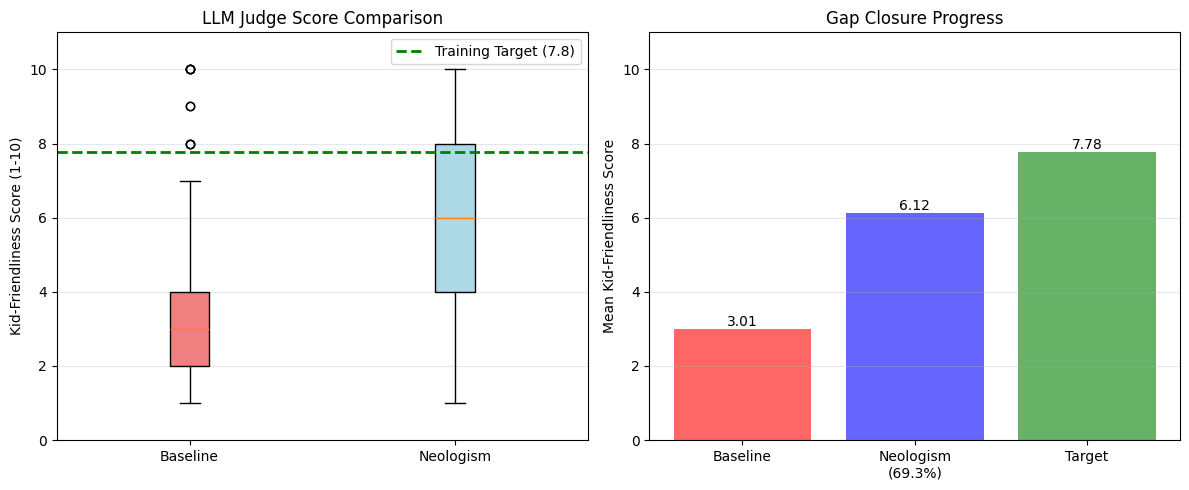

In [10]:
create_visualization(baseline_stats, training_stats, neo_stats, 
                        gap_results['gap_closure_pct'])

In [11]:
# Save results to JSON
import json

# Convert numpy types to Python types
def convert_to_serializable(obj):
    """Convert numpy types to JSON-serializable Python types."""
    if isinstance(obj, np.number):
        return float(obj)
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    else:
        return obj

results = {
    'training': {k: v for k, v in training_stats.items() if k != 'scores'},
    'baseline': {k: v for k, v in baseline_stats.items() if k != 'scores'},
    'neologism': {k: v for k, v in neo_stats.items() if k != 'scores'},
    'gap_closure': gap_results
}

# Convert all values
results = convert_to_serializable(results)

with open('kidmode_gap_closure_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✅ Results saved to kidmode_gap_closure_results.json")

✅ Results saved to kidmode_gap_closure_results.json
